In [5]:
# !pip install PyDrive
# !pip install --no-binary opencv-python opencv-python

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453


In [ ]:
'''Программа позволяет отследить положение того места на экране куда смотрит 
пользователь. Аппаратно реализовано на 2х веб камерах определенным образом закрепленных
на голове, адаптируется к поворотам и движениям головы относительно экрана. 
За основу взята предобученная VGG16, дообученная не набора изображений с камер.
Генерация набора выполняется автоматически и представляет собой захват с камер
во время наблюдения пользователем движения некоторой точки на экране.
В результате на валидации выборке достигалась точность RMSE порядка0.95, 
что давало на тесте получать среднее отклонение по диаметру от реального положения 
фокуса в раёне 150пикселей. 
'''

In [1]:
import warnings
warnings.filterwarnings("ignore")
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

In [ ]:
import cv2
def check_cam(id1: int=0, id2: int=2):
    '''Функция проверки камер, принимает id 2х камер, открывает их и выводит изображения
    в 2 отдельных окна'''
    cap1 = cv2.VideoCapture(id1)
    cap2 = cv2.VideoCapture(id2)
    cv2.namedWindow('Webcam 1')
    cv2.namedWindow('Webcam 2')

    while True:
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        cv2.imshow('Webcam 1', frame1)
        cv2.imshow('Webcam 2', frame2)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcams and destroy all windows
    cap1.release()
    cap2.release()
    cv2.destroyAllWindows()
check_cam()

In [3]:
cap1, cap2 = init_cameras(0, 2)
frame1, frame2 = get_frame(cap1, cap2)

QObject::moveToThread: Current thread (0x2ca3be0) is not the object's thread (0x31e15f0).
Cannot move to target thread (0x2ca3be0)

QObject::moveToThread: Current thread (0x2ca3be0) is not the object's thread (0x31e15f0).
Cannot move to target thread (0x2ca3be0)

QObject::moveToThread: Current thread (0x2ca3be0) is not the object's thread (0x31e15f0).
Cannot move to target thread (0x2ca3be0)

QObject::moveToThread: Current thread (0x2ca3be0) is not the object's thread (0x31e15f0).
Cannot move to target thread (0x2ca3be0)

QObject::moveToThread: Current thread (0x2ca3be0) is not the object's thread (0x31e15f0).
Cannot move to target thread (0x2ca3be0)

QObject::moveToThread: Current thread (0x2ca3be0) is not the object's thread (0x31e15f0).
Cannot move to target thread (0x2ca3be0)

QObject::moveToThread: Current thread (0x2ca3be0) is not the object's thread (0x31e15f0).
Cannot move to target thread (0x2ca3be0)

QObject::moveToThread: Current thread (0x2ca3be0) is not the object's thread

In [22]:
create_points(5)

[(0, 0),
 (480, 1080),
 (960, 0),
 (1440, 1080),
 (1920, 1080),
 (0, 810),
 (1920, 540),
 (0, 270),
 (1920, 0)]

In [24]:
import numpy as np
import cv2
import random
import pygamedata
import pickle

def init_cameras(id1: int=0, id2: int=2) -> (cv2.VideoCapture, cv2.VideoCapture):
    '''Инициализация и возврат 2х камер'''
    cap1 = cv2.VideoCapture(id1)
    cap2 = cv2.VideoCapture(id2)
    cv2.namedWindow('Webcam 1')
    cv2.namedWindow('Webcam 2')
    return (cap1, cap2)
    
def get_frame(cap1: cv2.VideoCapture, cap2: cv2.VideoCapture) -> (np.ndarray, np.ndarray):
    '''Функция захвата фреймов с 2х камер, предполагает, что устройства уже открыты глобально'''
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()
    cv2.imshow('Webcam 1', frame1)
    cv2.imshow('Webcam 2', frame2)
    return (frame1, frame2)

def setup_pygame(width: int=1920, heigth: int=1080) -> pygame.surface.Surface:
    '''Инииализация и возврат экрана. Принимает ширину и высоту окна'''
    pygame.init()
    screen = pygame.display.set_mode((0, 0), pygame.FULLSCREEN)
    screen.fill((255, 255, 255))  # white
    return screen

def create_points(n_points: int, window_width: int=1920, 
                  window_heigth: int=1080) -> list[(np.int64, np.int64)]:
    '''Функция создания точек по периметру экрана, между которыми будет бегать курсор 
    в количестве n_points на каждой из сторон экрана, порядок точек образует как бы 2 змейки,
    возвращает список кортежей координат точек по периметру экрана'''
    points = [] 
    x1 = np.linspace(0, window_width, n_points, dtype = 'int') #как линейное пространство от 0 до 
    y1 = np.array([0, window_heigth]*(n_points//2)) #максимальной ширины в количестве n_points
    x2 = np.array([0, window_width]*(n_points//2))
    y2 = np.linspace(window_heigth, 0, n_points, dtype = 'int')
    points = list(zip(np.append(x1,x2), np.append(y1,y2)))

    return points

def move_to_points(screen: pygame.surface.Surface, list_of_points: list,
                   cap1: cv2.VideoCapture, cap2: cv2.VideoCapture, n: int,
                   speed: int = 9999, capture: bool = True) -> list[dict]:
    '''Функция генерации данных(далее записей), принимает на вход pygame.screen, 
    список крайних точек между которыми она добавит промежуточные точки в количестве n,
    speed - скорость перехода между точками, флаг capture указывает на то нужно ли
    сохранять захваты с камер. Функция предполагает что если capture = True то 
    глобально уже существуют два устройства opencv: cap1 и cap2, которые через фунцию
    get_frame вернут 2 изображения, которые будут сохранены как соответствующие записи 
    в результирующем списке. Таким же образом будут сохранены координаты курсора. '''    
    data = [] # Результат работы функции накапливается здесь
    clock = pygame.time.Clock() #Часы для задания скорости
    for ((sx, sy),(ex,ey)) in zip(list_of_points[:-1], #Берем координаты текущей и 
                                  list_of_points[1:]): #следующей точки
        for x, y in zip(np.linspace(sx, ex, n, dtype='int'), #Бежим по промежуточным координатам
                        np.linspace(sy, ey, n, dtype='int')):#
            
            for event in pygame.event.get(): #Для прерывания цикла кнопкой q
                if event.type == pygame.QUIT or (event.type == pygame.KEYDOWN and event.key == pygame.K_q):
                    pygame.quit()
                    cap1.release()
                    cap2.release()
                    cv2.destroyAllWindows()
                    pygame.quit()  #Закрываем экран   
                    return

            screen.fill((255, 255, 255)) #Заливаем экран       
            pygame.draw.circle(screen, (0, 0, 0), [x,y], 5)   #Рисуем курсор в виде черного кружка в текущих координатах        
            clock.tick(speed) #Скорость            
            pygame.display.update() #Обновляем экран          
    
            if capture: #Делаем захват с камер, если нужно
                frame1, frame2 = get_frame(cap1, cap2)
            else:
                frame1, frame2 = [],[]
            data.append({'coords': (x,y), 'camera1':frame1, 'camera2':frame2}) #Делаем текущую запись
    cap1.release() #Отпускаем камеры   
    cap2.release() 
    cv2.destroyAllWindows() #Закрываем все окна
    pygame.quit()  #Закрываем экран   
    return data

In [21]:
n_points = 8 #Количество точек на каждой стороне периметра экрана
WINDOW_WIDTH = 1920 #Ширина экрана
WINDOW_HEIGTH = 1080 #Высота экрана

In [5]:
def make_data() -> list[dict]:
    '''Функция получения записей'''
    points = create_points(n_points, WINDOW_WIDTH, WINDOW_HEIGTH) #Создаем точки по периметру экрана
    screen = setup_pygame(WINDOW_WIDTH,WINDOW_HEIGTH) #Создаем pygame.surface.Surface
    cap1, cap2 = init_cameras(0,2) #Инициализируем камеры  
    data = move_to_points(screen, points, #Двигаем курсор в pygame.surface.Surface между points 
                          cap1, cap2, n=128, capture=True) #c шагом n, получая изображения с камер    
    return data
# data = make_data()

In [6]:

try: #Сохраняем  записи если они есть
    data
    with open('frame3.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
except: #Иначе загружаем сохраненные
    print('no data...load saved data')
    with open('frame3.pickle', 'rb') as handle:
        data = pickle.load(handle)          

no data


In [17]:
# data = data[::10] #Сокращенный набор для проверки корректности отработки кода

x:831, y:220


<Figure size 640x480 with 0 Axes>

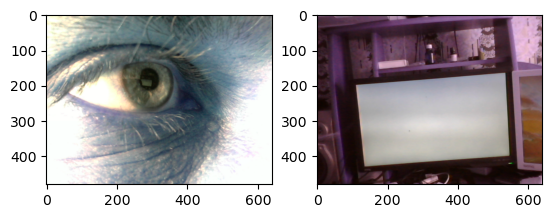

In [25]:
'''Посмотрим на одну случайную запись'''
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import random
item = random.choice(data)
img1, img2, (x, y) = item['camera1'], item['camera2'], item['coords']

plt.figure()
f, axis = plt.subplots(1,2)
print(f'x:{int(x)}, y:{int(y)}')
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axis[0].imshow(img1)
axis[1].imshow(img2)

In [50]:
type(data[0]['coords'][0])

numpy.int64

In [51]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torchvision.models as models
from torch import nn
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast, GradScaler

VAL_TEST_RATIO = 0.9 #Соотношение валидационных записей к тестовым
TRAIN_VALTEST_RATIO = 0.8 #Соотношение тренеровочных записей к вилидации+тест
BATCH_SIZE = 12 #Размер батча, в режиме половинной точности можно увеличить до 20

class EyeDataset(Dataset):
    '''Класс датасета'''
    def __init__(self, data):
        self.data = data
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        camera1 = self.data[idx]['camera1']
        camera2 = self.data[idx]['camera2']
        coords = self.data[idx]['coords']        
        return camera1, camera2, coords

def collate_batch(batch):
    '''Функция сборки батча. Батч представляет собой кортеж торчевых тензоров для изображения с
    камер, а также тензор координат. Соответствующие тензора мы получаем преобразуя массивы 
    изображений и координат, переводя их из целочисленного типа 0..255 в флот 0..1'''
    camera1, camera2, coords = [],[],[]
    for _data in batch:    
        camera1.append(_data[0]/256)
        camera2.append(_data[1]/256)
        coords.append((_data[2][0]/WINDOW_WIDTH, _data[2][1]/WINDOW_HEIGTH))       
    camera1, camera2, coords = np.array(camera1), np.array(camera2), np.array(coords)
    return torch.FloatTensor(camera1), torch.FloatTensor(camera2), torch.FloatTensor(coords)
    

train_records, val_test_records = train_test_split(data, train_size=TRAIN_VALTEST_RATIO, 
                                             random_state=42)
val_records, test_records = train_test_split(val_test_records, train_size=VAL_TEST_RATIO, 
                                             random_state=42)

In [56]:
len(train_records), len(val_records), len(test_records)

(1536, 345, 39)

In [57]:
type(test_dataset[0][2][0])

numpy.int64

In [58]:
'''Создаем тренеровочный, валидационный и тестовый датасеты из записей,
а так же соответствующие им лоадеры'''
train_dataset, val_dataset, test_dataset = EyeDataset(train_records), EyeDataset(val_records), EyeDataset(test_records)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE//2, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE//2, shuffle=False, collate_fn=collate_batch)

In [59]:
%%timeit
item = next(iter(train_loader))

8.14 s ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
'''Для обработки изображений будем использовать 2 независимых предобученных
реснета50 для каждого изображения'''
res50_1 = models.resnet50(pretrained=True)
res50_2 = models.resnet50(pretrained=True)


In [14]:
'''Заменим выходные классификаторы'''
PRECLS_OUT = 48
res50_1.fc= nn.Linear(2048, PRECLS_OUT)
res50_2.fc= nn.Linear(2048, PRECLS_OUT)

In [15]:
class EyeTracker(nn.Module):
    '''Класс модели для задачи определения направления взгляда
    обе головы работают независимо, выход их классификатора конкатится,
    далее следует уже кончный классификатор в виде 2х полносвязных слоев'''
    def __init__(self, precls_out):
        super(EyeTracker, self).__init__()
        self.res50_1 = res50_1
        self.res50_2 = res50_2
        self.dropout = nn.Dropout(0.01)
        self.fc1 = nn.Linear(precls_out*2, precls_out)
        self.fc2 = nn.Linear(precls_out, 2)
        self.activ = nn.ReLU()

    def forward(self, image1, image2):
        out1 = self.res50_1(image1)
        out1 = self.dropout(out1)
        out2 = self.res50_2(image2)
        out1 = self.dropout(out2)

        out = torch.cat((out1, out2),dim=1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.activ(out)
        out = self.fc2(out)       
        return out   

class RMSELoss(nn.Module):
    '''Класс функции потерь, представляющий собой декартово расстояние между предсказанной
    и реальной точкой. Построен на базе стандартного торчевого MSE лосса'''
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, pred, true):
        mse = nn.MSELoss()
        mse_loss = mse(pred, true)
        rmse_loss = torch.sqrt(mse_loss)
        return rmse_loss

In [16]:
from scipy.ndimage.filters import gaussian_filter1d
'''Функция отрисовки истории обучения со сглаживанием'''

def plot_history(train_history: list, val_history: list, batch_size=BATCH_SIZE):    
    fig = plt.figure(figsize=(12, 4))
    '''Блок для трейн лосса'''
    ax1 = fig.add_subplot()    
    ax1.plot(gaussian_filter1d(train_history, sigma=128/batch_size), 
             label='Train loss', color = 'steelblue')    
    ax1.set_yticks(np.linspace(min(train_history+val_history), max(train_history+val_history), 10,  
                               dtype='float16'))   
    ax1.set_ylabel('Loss')                
    ax1.set_xlabel('Batch')  
    ax1.grid(axis = 'y')   

    '''Блок для валидационного лосса'''    
    ax2 = ax1.twiny()       
    ax2.plot(val_history, label='Valid loss', color = 'orange')            
    ax2.set_xlabel('Epochs')
    ax2.set_xticks(np.arange(len(val_history))) 
    ax2.grid()
    
      
    '''Легенда'''
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()    
    
    ax1.legend(handles=handles1+handles2, labels=labels1+labels2, 
               loc='center right')    
    plt.show()

In [17]:
import torchvision
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EyeTracker(PRECLS_OUT).to(device)#.half()

In [20]:
%%time
from torch.optim import Adam, AdamW, lr_scheduler
from IPython.display import clear_output

EPOCHS = 15
lr_cnn = 1e-5
lr_cls = 1e-3

criterion = RMSELoss() #Лосс
scaler = GradScaler() #Скэлер для масштабирования градиента, для смешанного режима обучения

optimizer_cnn = Adam([
    {'params': model.res50_1.parameters()}, #Оптимизатор сверотчных частей
    {'params': model.res50_2.parameters()}], lr = lr_cnn)

optimizer_cls = Adam([
    {'params': model.res50_1.fc.parameters()}, #Оптимизатор полносвязных частей
    {'params': model.res50_2.fc.parameters()},
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}], lr = lr_cls)

'''Планировщики для сверточной и полсносвязной частей'''
scheduler_cnn = lr_scheduler.StepLR(optimizer_cnn, step_size=1,
                                    gamma=0.5, verbose=False)
scheduler_cls = lr_scheduler.StepLR(optimizer_cls, step_size=1, 
                                    gamma=0.5, verbose=False)

def test_model(model, test_loader, criterion):
    model.eval()
    cum_loss = []
    criterion = RMSELoss()
    with torch.no_grad():

        for batch in tqdm(test_loader):
            image1, image2, coords = batch
            image1 = image1.permute(0,3,2,1).to(device)#.half()
            image2 = image2.permute(0,3,2,1).to(device)#.half()
            target = coords.to(device)
            out = model(image1, image2)
            loss = criterion(out, target).cpu().item()                
            cum_loss.append(loss)

        loss = np.mean(cum_loss)        
        return loss

def evaluate_model(model, loader):
    model.eval()
    pred = []
    with torch.no_grad():
        for batch in tqdm(loader):
            image1, image2, coords = batch
            image1 = image1.permute(0,3,2,1).to(device)#.half()
            image2 = image2.permute(0,3,2,1).to(device)#.half()
            target = coords.to(device)
            out = model(image1, image2)
            pred.append(out)               
        return pred

def train(model, criterion, optimizer_cnn, optimizer_cls, scheduler_cnn, scheduler_cls,
          EPOCHS, train_loader, val_loader, scaler=None, half=False,):
    train_history = []
    val_history = []
    best_loss = 5
    cnt = 0
    LOG = []
    for epoch in range(1, EPOCHS+1):
        print(f'Epoch:{epoch}/{EPOCHS}')
        model.train()
        pbar = tqdm(train_loader)
        for batch in pbar:
            optimizer_cnn.zero_grad()           
            optimizer_cls.zero_grad()     
            image1, image2, coords = batch          
            
            image1 = image1.permute(0,3,2,1).to(device)
            image2 = image2.permute(0,3,2,1).to(device)
            target = coords.to(device)
            if half:
                with autocast():
                    out = model(image1.half(), image2.half())
                    loss = criterion(out, target.half())
                scaler.scale(loss).backward()
                scaler.step(optimizer_cnn)
                scaler.step(optimizer_cls)
                scaler.update()
            else:
                out = model(image1, image2)
                loss = criterion(out, target)
                loss.backward()
                optimizer_cnn.step()        
                optimizer_cls.step()  
                
            train_history.append(loss.detach().cpu().numpy())  
            pbar.set_description(f'''Train Loss: {train_history[-1]:.2f}, 
                                 emb_lr: {optimizer_cnn.param_groups[0]['lr']:.2E},
                                 cls_lr: {optimizer_cls.param_groups[0]['lr']:.2E}''')  

        '''Валидация'''
        val_loss = test_model(model, val_loader, criterion)        
        if epoch == 1:
            val_history.append(np.mean(train_history[:10]))         
        else:
            val_history.append(val_loss)        
        
        train_loss = np.mean(train_history[-len(train_records)//BATCH_SIZE//10:])
        epoch_time = int(pbar.format_dict['elapsed'])         
        LOG.append(f'Epoch:{epoch} Train loss:{train_loss:.3f} '+
                   f'Val loss:{val_loss:.3f} '+
                   f'Epoch time:{epoch_time:d}s ')
        
        print(f'Val_loss: {val_loss:.3f} Train loss: {loss:.3f}\n') 
        clear_output()
        print(*LOG, sep = '\n')
        plot_history(train_history[2:], val_history, batch_size=BATCH_SIZE)
        if val_loss < best_loss:        
            print(f'***Save the best model***\n')
            torch.save(model, './best_resnet_pcls48_wodo_loss_model.pth')                 
            best_loss = val_loss
            cnt = 0   
        else: # Иначе увеличиваем счетчик, и если он уже больше определенного значения, понижаем lr
            cnt += 1
            if cnt >=3:  
                print('***Adjusting learning rate, reload best model***')
                LOG[-1] = LOG[-1]+'reduce LR'
                model = torch.load('./best_resnet_pcls48_wodo_loss_model.pth').to(device)
                scheduler_cnn.step()
                scheduler_cls.step()
        #Если счетчик достиг критического значения, выходим из обучения'''
        if cnt == 5:
            print('Stop training')            
            break
    return model, train_history, val_history
    
# model = torch.load('./best_resnet_pcls48_wodo_loss_model.pth')
# model, train_history, val_history = train(model,criterion, optimizer_cnn, optimizer_cls, scheduler_cnn, scheduler_cls,
#                                           EPOCHS, train_loader, val_loader, scaler=scaler, half=True)

CPU times: user 3.18 ms, sys: 0 ns, total: 3.18 ms
Wall time: 3.2 ms


In [21]:
model = torch.load('./best_resnet_pcls48_wodo_loss_model.pth').to(device)
# torch.save(model, './best_resnet_pcls48_wodo_loss_model.pth')
test_model(model, test_loader, criterion)

  0%|          | 0/7 [00:00<?, ?it/s]

0.09849994629621506

In [22]:
all_loader = DataLoader(EyeDataset(data), batch_size=1, shuffle=False, collate_fn=collate_batch)

In [23]:
import time
def frames_to_tensor(frame1, frame2) -> (torch.FloatTensor, torch.FloatTensor):
    '''Функция принимает 2 массива RGB изображения 0..255 и возвращает торчевые
    тензора 0..1 той же формы'''
    frame1 = frame1/255
    frame2 = frame2/255
    return torch.FloatTensor(frame1), torch.FloatTensor(frame2)
    
def eye_track(model, id1=0, id2=2, half = False):      
    '''Функция отслеживания направления взгляда, принимает модель, id камер, флаг смешанного режима'''
    cap1, cap2 = init_cameras(0, 2) #Инициализируем камеры
    screen = setup_pygame(WINDOW_WIDTH,WINDOW_HEIGTH) #Инициализируем surface
    if half: model = model.half() #Переодим модель в смешанный режим если требуется
    while True:
        for event in pygame.event.get(): #Для прерывания цикла кнопкой q
            if event.type == pygame.QUIT or (event.type == pygame.KEYDOWN and event.key == pygame.K_q):
                cap1.release()
                cap2.release()
                cv2.destroyAllWindows()
                pygame.quit()
                return

        screen.fill((255, 255, 255)) #Заливаем экран  
        frame1, frame2 = get_frame(cap1, cap2) # Получаем изображения
        frame1, frame2 = frames_to_tensor(frame1, frame2) # Преобразуем в тензора   
    
        image1 = frame1.unsqueeze(0).permute(0,3,2,1).to(device) # Добавляем батч измерение,
        image2 = frame2.unsqueeze(0).permute(0,3,2,1).to(device) # меняем канальное измерение
        '''Смешанный режим режим, если требуется !!!ПРОВЕРИТЬ БЕЗ НЕГО!!! ''' 
        if half: image1, image2 = image1.half(), image2.half()
        '''Инференс: прогоняем картинки через модель получаем координаты растягиваем на экран'''
        x, y = model(image1, image2)[0].cpu()*torch.Tensor([WINDOW_WIDTH, WINDOW_HEIGTH]) 
        '''Делаем клип, преобразуем в инт'''
        x, y = int(torch.clip(x, 0, WINDOW_WIDTH)), int(torch.clip(y, 0, WINDOW_HEIGTH))
        ''' #Рисуем курсор в виде черного кружка в текущих координатах'''   
        pygame.draw.circle(screen, (0, 0, 0), [x,y], 5)       
           
        pygame.display.update() #Обновляем экран       

#     pygame.quit()  #Закрываем экран   
#     cap1.release()
#     cap2.release()
#     cv2.destroyAllWindows()


def calc_mean_error(model, loader, draw = False):   
    '''Функция вычисления ошибки в пикселях для теста, принимает модель, загрузчик, флаг отрисовки'''
    pbar = tqdm(loader) 
    pred = [] #Список предсказанных координат
    true = [] #Список реальных координат
    for record in pbar: #Для записи из загрузчика
        frame1, frame2 = record[0], record[1] #Изображения
        image1 = record[0].permute(0,3,2,1).to(device)#.half()№ # Добавляем батч измерение,
        image2 = record[1].permute(0,3,2,1).to(device)#.half() # меняем канальное измерение
        '''Получаем реальные координаты из записи, переводим на cpu натягиваем на экран'''
        (tx, ty) = record[2][0].cpu()*torch.Tensor([WINDOW_WIDTH, WINDOW_HEIGTH]) 
        '''Предсказываем координаты, переводим на cpu натягиваем на экран '''
        (x, y) = model(image1, image2)[0].cpu()*torch.Tensor([WINDOW_WIDTH, WINDOW_HEIGTH])
         '''Делаем клип, преобразуем в инт'''
        x, y = int(torch.clip(x, 0, WINDOW_WIDTH)), int(torch.clip(y, 0, WINDOW_HEIGTH)) #
        pred.append((x,y)) # Добавляем предсказанные координаты в список
        true.append((int(tx), int(ty))) # Добавляем реальные координаты в список
        
    tx, ty = zip(*true) # Перепаковываем
    px, py = zip(*pred) #   
    if draw:
        for i in range(len(px)): #
            plt.xlim(0, WINDOW_WIDTH) #
            plt.ylim(0, WINDOW_HEIGTH) #
            plt.scatter(tx[i], ty[i]) #
            plt.scatter(px[i], py[i]) #
            plt.show()#
            clear_output(wait=True) #
    errors = [] #
    for txx, pxx, tyy, pyy in zip (tx, px, ty, py): #
        errors.append(((txx-pxx)**2+(tyy-pyy)**2)**.5) #        
    return np.mean(errors)

# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_batch)
# calc_mean_error(model, test_loader, draw=True)

eye_track(model, id1=0, id2=2, half = True)

QObject::moveToThread: Current thread (0x2ed93c0) is not the object's thread (0x33e4620).
Cannot move to target thread (0x2ed93c0)

QObject::moveToThread: Current thread (0x2ed93c0) is not the object's thread (0x33e4620).
Cannot move to target thread (0x2ed93c0)

QObject::moveToThread: Current thread (0x2ed93c0) is not the object's thread (0x33e4620).
Cannot move to target thread (0x2ed93c0)

QObject::moveToThread: Current thread (0x2ed93c0) is not the object's thread (0x33e4620).
Cannot move to target thread (0x2ed93c0)

QObject::moveToThread: Current thread (0x2ed93c0) is not the object's thread (0x33e4620).
Cannot move to target thread (0x2ed93c0)

QObject::moveToThread: Current thread (0x2ed93c0) is not the object's thread (0x33e4620).
Cannot move to target thread (0x2ed93c0)

QObject::moveToThread: Current thread (0x2ed93c0) is not the object's thread (0x33e4620).
Cannot move to target thread (0x2ed93c0)

QObject::moveToThread: Current thread (0x2ed93c0) is not the object's thread

In [31]:
# cap1.release()
# cap2.release()
cv2.destroyAllWindows()
pygame.quit()

NameError: name 'cap1' is not defined